In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
import scipy.ndimage
from astropy import units as u
import time

from scalessim.DFT import *
from scalessim.binning import *
from scalessim.phasescreen import *
from scalessim.pupil import *
from scalessim.io import *
from scalessim.focal_plane import *
from scalessim.targs import *
from scalessim.base import *
from scalessim.helpers import *

# SCALES low-res SED example

This notebook runs through all the steps for 

(1) setting up an HR8799 analog input scene
(2) feeding that input cube to scalessim and generating a raw image
(3) generating a cube of images from the raw spectral traces

# SET UP HR8799 SCENE HERE

In [2]:
seps=np.array([1.75/.02, 0.97/.02, 0.62/.02, 0.37/.02])
position_angles=np.deg2rad([45.0, -30.0, -160.0, -90.0])
b,c,d,e = np.array([54+seps*np.cos(-position_angles), 54+seps*np.sin(-position_angles)]).T
print(b,c,d,e)

[115.87184335  -7.87184335] [96.00223208 78.25      ] [24.86952876 64.60262444] [54.  72.5]


In [3]:
def get_spectrum(obj='b', nlam=75):
    objs = {'A':1, 'b':2, 'c':3, 'd':4, 'e':5}
    num = objs[obj]
    spec = fits.getdata('hr8799_inputs/spectrum_'+str(num)+'.fits')
    
    order = np.argsort(spec[:,0])
    lams = spec[order][:,0]
    spec = spec[order][:,1]
    return spectres(np.linspace(1.9,5.3,341), lams, spec)

In [4]:
Aspec = get_spectrum('A')
bspec = get_spectrum('b')
cspec = get_spectrum('c')
dspec = get_spectrum('d')
espec = get_spectrum('e')


In [5]:
lams_binned=np.linspace(1.9,5.3,341) ###do not change
##create empty cube for scene
scene = np.zeros([len(lams_binned),108,108])
##central point source
scene[:,54,54] = Aspec
##c
scene[:,int(np.round(c[0])),int(np.round(c[1]))] = cspec
##d
scene[:,int(np.round(d[0])),int(np.round(d[1]))] = dspec
##e
scene[:,int(np.round(e[0])),int(np.round(e[1]))] = espec


###create second scene with just central star
scene_s = np.zeros([len(lams_binned),108,108])
scene_s[:,54,54] = Aspec



## Configure your H2RG

Load in h2rg configuration file 

In [6]:
import configparser
from detector import nghxrg as ng

config = configparser.ConfigParser()
config.read('h2rg.ini')

arg_detector = {}
arg_detector.update(read_ini(config['Defined']))

ng_h2rg = ng.HXRGNoise(verbose=False,
                        wind_mode='WINDOW',
                        naxis1=1024, naxis2=1024,
                        pca0_file='./detector/lmircam_pca0.fits')


Define some reasonable noise parameters

In [7]:
rd_noise=arg_detector['readout_noise_cds']*1.   # White read noise per integration
pedestal=arg_detector['pedestal']*1.   # DC pedestal drift rms
c_pink=arg_detector['c_pink']*1.     # Correlated pink noise
u_pink=arg_detector['u_pink']*1.     # Uncorrelated pink noise
acn=arg_detector['acn']*1.        # Correlated ACN
pca0_amp=arg_detector['pca0_amp']*1.   # Amplitude of PCA zero "picture frame" noise

## Configure SCALES mode

Read in SCALES config file for H2RG

In [8]:
config.read('scales_h2rg.ini')
arg_spaxel = {}
arg_spaxel.update(read_ini(config['Defined']))
arg_spaxel.update(read_ini(config['Derived']))
arg_spaxel.update(read_ini(config['User']))

In [9]:
wav_min = 2.0
wav_max = 5.2
arg_spaxel['min_wavelength'] = wav_min #minimum wavelength in microns
arg_spaxel['max_wavelength'] = wav_max #maximum wavelength in microns

## Set up lenslet traces

In [10]:
lens = Lenslet(arg_spaxel)
lens.get_shifts()
lens.make_trace(phys=True,disp=True,verbose=True)

2.0_5.2_prism.txt


## Read in Keck pupil

In [11]:
keck = fits.getdata('keckpupil.fits')
keck = scipy.ndimage.zoom(keck, 10, order=0)
pupil = Pupil()
pupil.pupil = keck

screen1 = np.zeros(pupil.pupil.shape) ###leaving out residual AO errors for now

## Use pupil and residual phase to generate cube of Keck PSFs

In [12]:
nspax = arg_spaxel['no_spaxel']
nlam = lens.trace.shape[0]
keck_cube = np.zeros((nlam, nspax, nspax))
mag1 = magn(lens.lmin)
mag2 = magn(lens.lmax)

psf_file = 'keck_psf_cube_'+str(lens.lmin)+'_'+str(lens.lmax)+'_n'+str(nlam)+'.fits'
if os.path.isfile(psf_file)==False:
    for i, mag in enumerate(np.linspace(mag1, mag2, nlam)):
        W = DFT_matrix(1600, mag)
        A = pupil.pupil * np.exp(1.j * screen1)
        out = abs(W.dot(A).dot(W))**2
        out /= np.sum(out, axis=(0,1))
        keck_cube[i] = frebin(out, (108, 108))
    fits.writeto(psf_file,np.array(keck_cube),clobber=True)
else: keck_cube = pyfits.getdata(psf_file)

## Define some observational parameters

-Reads in sky transmission and emission models provided by Gemini for MK site: https://www.gemini.edu/observing/telescopes-and-sites/sites#IRSky

-Reads in atmospheric dispersion data based on relative humidity, temperature, pressure, and airmass

-Instrument transmission & emission includes SCALES + AO emissivity

-Default QE is 70%

-For now set up perfect filter with tophat from lmin to lmax

-Define single frame integration time in seconds

In [13]:
vapor = 1 #PWV in mm
airmass = 1 
skybg = SkyBG(vapor,airmass)
skytrans = SkyTrans(vapor,airmass)
atmodisp = AtmoDispersion(90,20,600)
inst_emissivities = [.08]*3 + [.01]*8
inst_temps = [273*u.K]*11
inst = InstTransEm(inst_emissivities, inst_temps)
qe = QE()
filt = Filter(lmin=lens.lmin,lmax=lens.lmax)
dit = 1 ###integration time in seconds

In [14]:
####organize all these and pass to focal_plane 
args_new = {'Lenslet_object':lens,
            'SkyBG':skybg,
            'SkyTrans':skytrans,
            'InstTransEm':inst,
            'Filter':filt,
            'QE':qe}
fp = FocalPlane(args_new)

## Convolve scene with PSF 

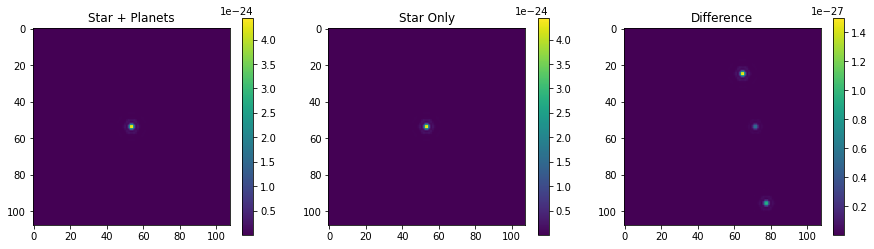

In [15]:
FT_psf = np.array([np.fft.fft2(keck_cube[i]) for i in range(len(keck_cube))])

FT_scene = np.array([np.fft.fft2(scene[i]) for i in range(len(scene))])
FT_conv = FT_psf*FT_scene
scene_conv = np.array([np.real(np.fft.ifftshift(np.fft.ifft2(FT_conv[i]))) for i in range(len(scene))])


FT_scene_s = np.array([np.fft.fft2(scene_s[i]) for i in range(len(scene_s))])
FT_conv_s = FT_psf*FT_scene_s
scene_conv_s = np.array([np.real(np.fft.ifftshift(np.fft.ifft2(FT_conv_s[i]))) for i in range(len(scene))])

f = plt.figure(figsize=(15,4))
f.add_subplot(131)
plt.imshow(scene_conv[0])
plt.colorbar()
plt.title('Star + Planets')
f.add_subplot(132)
plt.imshow(scene_conv_s[0])
plt.colorbar()
plt.title('Star Only')
f.add_subplot(133)
plt.imshow((scene_conv[0]-scene_conv_s[0]))
plt.colorbar()
plt.title('Difference')
plt.show()

## Generate a raw SCALES frame for star + planets using input cube

In [16]:
scene_conv_units = scene_conv*u.erg / u.cm**2 / u.micron / u.s
scene_conv_units_s = scene_conv_s*u.erg / u.cm**2 / u.micron / u.s
t1 = time.time()
raw_p, bg_star_truth = fp.get_fp(dit*u.s,cube=scene_conv_units,return_full=True,bg_off=True)
t2 = time.time()
print(t2-t1)



t1 = time.time()
raw_s, bg_star_truth = fp.get_fp(dit*u.s,cube=scene_conv_units_s,return_full=True,bg_off=True)
t2 = time.time()
print(t2-t1)

using cube
making full raw image
83.74543499946594
using cube
making full raw image
84.38205480575562


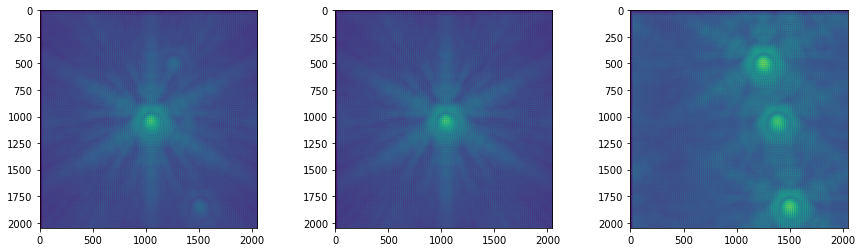

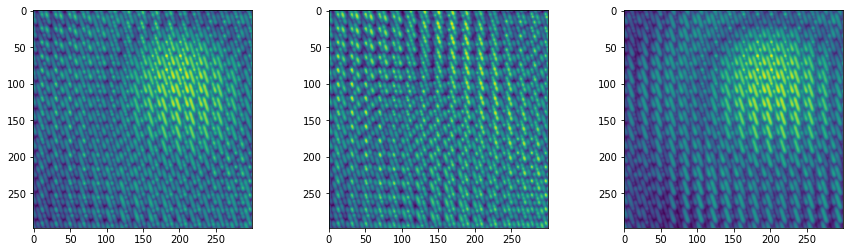

In [17]:
f = plt.figure(figsize=(15,4))
f.add_subplot(131)
plt.imshow(raw_p**0.1)
f.add_subplot(132)
plt.imshow(raw_s**0.1)
f.add_subplot(133)
plt.imshow((raw_p-raw_s)**0.1)
plt.show()

f = plt.figure(figsize=(15,4))
f.add_subplot(131)
plt.imshow(raw_p[1750:2048,1300:1600]**0.1)
f.add_subplot(132)
plt.imshow(raw_s[1750:2048,1300:1600]**0.1)
f.add_subplot(133)
plt.imshow((raw_p-raw_s)[1750:2048,1300:1600]**0.1)
plt.show()


pyfits.writeto('hr8799_planets_only_raw.fits',np.array(raw_p-raw_s),clobber=True)
pyfits.writeto('hr8799_star_only_raw.fits',np.array(raw_s),clobber=True)
pyfits.writeto('hr8799_raw.fits',np.array(raw_p),clobber=True)

In [18]:
 def extract_using_trace(frame,llens):
    poss = llens.args['spaxel_size_px'] * np.arange(fp.num_spaxel)
    cinds = np.where(np.abs(fp.lam.value - llens.lmin)<1.0e-6)[0][0]
    cinde = np.where(np.abs(fp.lam.value - llens.lmax)<1.0e-6)[0][0]
    lamsx = fp.lam[cinds:cinde+1]
    toextr=llens.trace.copy()[cinds:cinde+1]
    bes = np.linspace(wav_min,wav_max,55)
    lams = 0.5*(bes[0:-1]+bes[1:])
    toextr_bin = np.zeros([54,toextr.shape[1],toextr.shape[2]])
    for xx in range(len(lamsx)):
        lam = lamsx[xx].value
        for yy in range(len(bes)-1):
            if lam > bes[yy]:
                if lam < bes[yy+1]:
                    toextr_bin[yy]+=toextr[xx]       
    xloc = llens.xx[cinds]
    yloc = llens.yy[cinds]
    cube_out = np.zeros([len(toextr_bin),108,108])
    for ll in range(len(toextr_bin)):
        tinp = toextr_bin[ll]
        toadd = np.zeros([tinp.shape[0]+2,tinp.shape[1]+2])
        dyt = len(toadd)
        dxt = len(toadd[0])
        toadd[1:1+len(tinp),1:1+len(tinp[0])] = np.array(tinp)
        for ii in range(108):
            for jj in range(108):
                sdx = poss[ii]-xloc
                sdy = poss[jj]-yloc
                imy = int(sdy)
                imx = int(sdx)
                dimy = sdy-imy
                dimx = sdx-imx
                toadd2 = shift(toadd,(dimy,dimx),order=1,prefilter=False)
                if imy > 0:
                    if imx > 0:
                        if imx+dxt < 2048:
                            if imy+dyt < 2048:
                                specex = np.sum(frame[imy:imy+dyt,imx:imx+dxt]
                                        [np.where(toadd2 > np.max(toadd2)*0.25)])
                                cube_out[ll,jj,ii] = specex
                            else: cube_out[ll,jj,ii] = np.nan
                        else: cube_out[ll,jj,ii] = np.nan
                    else: cube_out[ll,jj,ii] = np.nan
                else: cube_out[ll,jj,ii]=np.nan
    return np.array(cube_out),np.array(lams)

# Extract using trace on the fly

In [19]:
t1 = time.time()
cube_s_e,lams_s_e = extract_using_trace(raw_s,lens)
t2 = time.time()
print(t2-t1)

t1 = time.time()
cube_p_e,lams_p_e = extract_using_trace(raw_p,lens)
t2 = time.time()
print(t2-t1)

114.29471111297607
113.57653403282166


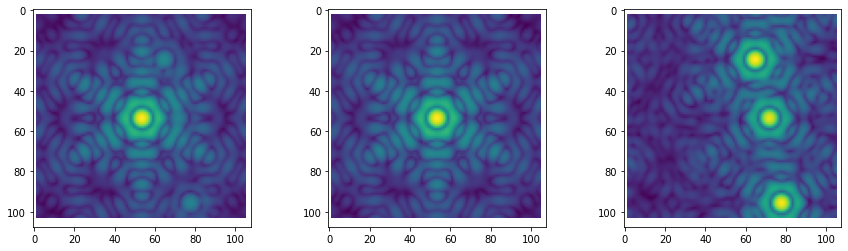

In [57]:
ind = -10
f = plt.figure(figsize=(15,4))
f.add_subplot(131)
plt.imshow(cube_p_e[ind]**0.1)
f.add_subplot(132)
plt.imshow(cube_s_e[ind]**0.1)
f.add_subplot(133)
plt.imshow((cube_p_e-cube_s_e)[ind]**0.1)
plt.show()

# Extract using pre-computed rectification matrix (generated from traces)

In [60]:
from scipy import sparse

raw_p_f = np.matrix(raw_p_f.flatten()).T
raw_s_f = np.matrix(raw_s_f.flatten()).T
rectmat = sparse.load_npz('rectmats/2.0_5.2_rectmat.npz')
nlam = 54
nx = nspax
ny = nspax

cube_p_f = rectmat*raw_p_f
cube_s_f = rectmat*raw_s_f

cube_p_t = np.array(cube_p_f).reshape(nlam,ny,nx)
cube_s_t = np.array(cube_s_f).reshape(nlam,ny,nx)

cube_p = []
cube_s = []
for i in range(len(cube_p_t)):
    cube_p.append(cube_p_t[i].T)
    cube_s.append(cube_s_t[i].T)
cube_p = np.array(cube_p)
cube_s = np.array(cube_s)



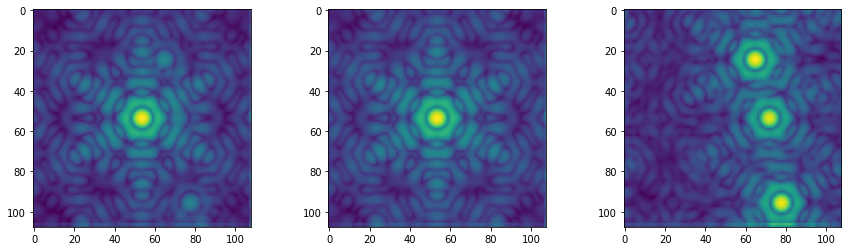

In [74]:
ind = -10

f = plt.figure(figsize=(15,4))
f.add_subplot(131)
plt.imshow(cube_p[ind]**0.1)
f.add_subplot(132)
plt.imshow(cube_s[ind]**0.1)
f.add_subplot(133)
plt.imshow((cube_p[ind]-cube_s[ind])**0.1)
plt.show()